**Difference Between Regression And Classification** - 

* In Regression problem, we train the model to predict a continuous value(given a set of input features).

* In Classification problem, we train the model to predict discrete values or classes. 

# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
# tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Libraries imported.')

Libraries imported.



1. tf.logging  - It is for logging and summary operations.
2. tf.logging -> tf.compat.v1.logging  -> Because in TF 2.0 it has been removed.



# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [0]:
column_names=['serial', 'date', 'age', 'distance', 'stores', 'latitude', 'longitude', 'price']

In [3]:
df = pd.read_csv('/content/data.csv', names = column_names)
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [4]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

**Note** - 

1. True - If value is misisng 

2. False - If value is not missing

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

**Note** - 

1. In Normalization, we will try to minimize the differenece between ground truth and the model's prediction.

2. Normalization simply change the distribution of different features so that values of different features are in similar ranges.

3. Normalization is also used when features are scalar. 

4. iloc means you are selecting data for your rows and columns.

    df = df.iloc[:, 1:] -> df.iloc[rows, columns]

    rows -> : -> take all rows

    columns -> 1: -> take all columns except 1st column
  

**Normalization** - 



In [5]:
df=df.iloc[:,1:]
df_norm = (df-df.mean())/df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [6]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
  return int(pred*y_std+y_mean)

print("Check value:",convert_label_value(0.350088))

Check value: 14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [7]:
x=df_norm.iloc[:, :-1]
x.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [8]:
y = df_norm.iloc[:, -1]
y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

**Note** - 

1. numpy arrays are compatible. 

In [9]:
x_arr = x.values
y_arr = y.values

print("features array shape:", x_arr.shape)
print("labels array shape:", y_arr.shape)

features array shape: (5000, 6)
labels array shape: (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

**Note** - 

1. We split the data into two sets so that one(test set) of them can be used for validation, evaluation or testing.

2. Difference between validation and evaluation - 

* Validation is used to tune the hyper-parameters of the model and is done on the cross validation set. 

* Evaluation is used to test the final performance of the algorithm and is done on the test set.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr,
                                                    test_size = 0.2, random_state = 0)

print("Training set:", x_train.shape, y_train.shape)
print("Test set:", y_test.shape, y_test.shape)

Training set: (4000, 6) (4000,)
Test set: (1000,) (1000,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

**Note** - 

1. We are using simple neural architecture with just 3 hidden layer. We are going to use relu (Rectified Linear Unit) activation function on all the layers. 

In [11]:
def get_model():
  # we have 3 hidden layer 
  # 10, 20, 5 -> nodes 
  # these are all fully connected layer. 
  model = Sequential([
                      Dense(10, input_shape = (6,), activation = 'relu'),
                      Dense(20, activation = 'relu'),
                      Dense(5, activation = 'relu'),
                      Dense(1)   # this is for output layer 
  ])
  model.compile(
      # mse -> mean square error
      loss = 'mse',
      optimizer = 'adam'
  )
  return model

get_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


**Note** - 

1. Param(dense_2) = [node(dense_2) * node(dense_1)] + [node (dense_2) * node(output_layer)]

# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

**Note** - 

* Validation loss is calculated on test set, not on training set. 

* Model will simply stop training where it doesn't see any improvement in the validation loss. 

* es = EasyStopping(monitor = 'val_loss', patience = 5) -> 

    EarlyStopping -> callback function

    patience = 5 -> If upto 5 epochs there will be very less chanegs in validation_loss then it will stop training the model.

    es -> If val_loss doesn't decrease for 5 epochs then it will stop the training. 

* history(It is an object) will return validation loss across different epochs.

**Training Loss And Validation Loss** - 

1. Training Loss - Training loss is the error on the training set of data.

2. Validation Loss - 

3. There are 3 cases - 

    * Underfitting - loss > validation_loss

    * Overfitting - loss << validation_loss. This means that your model is fitting very nicely the training data but not at all the validation data, in other words it's not generalizing correctly to unseen data

    * Perfect Fitting - loss == validation_loss. f both values end up to be roughly the same and also if the values are converging (plot the loss over time) then chances are very high that you are doing it right.

In [12]:
es=EarlyStopping(monitor = 'val_loss', patience = 5)

# creating model
model=get_model()
# predictions on untrained model. Untrained model will mostly give you random predictions.
predictions_on_untrain_model = model.predict(x_test)

history = model.fit( 
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 100,
    callbacks = [es]
)

Epoch 1/100
125/125 [==============================] - 0s 3ms/step - loss: 0.6218 - val_loss: 0.2594
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 0.2166 - val_loss: 0.1872
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 0.1786 - val_loss: 0.1696
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 0.1686 - val_loss: 0.1648
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 0.1641 - val_loss: 0.1623
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 0.1613 - val_loss: 0.1636
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 0.1600 - val_loss: 0.1599
Epoch 8/100
125/125 [==============================] - 0s 2ms/step - loss: 0.1574 - val_loss: 0.1594
Epoch 9/100
125/125 [==============================] - 0s 2ms/step - loss: 0.1566 - val_loss: 0.1561
Epoch 10/100
125/125 [==============================] - 0s 2ms/step - loss: 0.1553 - val_lo

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

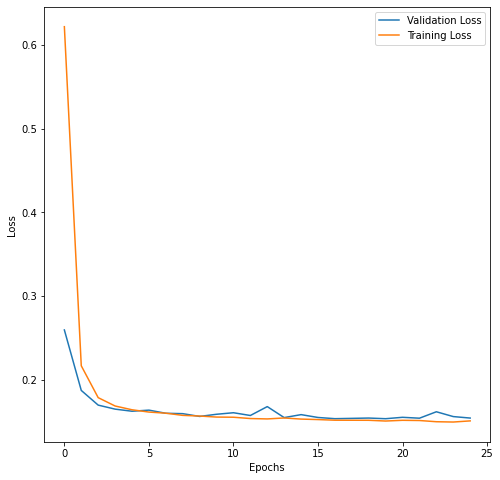

In [13]:
plot_loss(history)

**Note** - 

1. Training Loss 

2. Validation Loss

**Observation** - 

1. Training loss and Validation loss value decreased as the training went on.

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

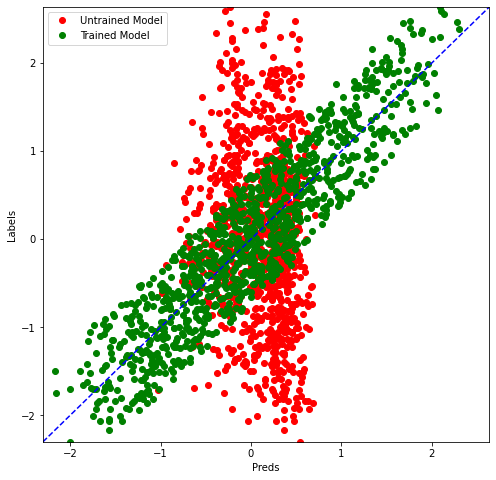

In [14]:
predictions_on_train_model = model.predict(x_test)
compare_predictions(predictions_on_untrain_model, predictions_on_train_model, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

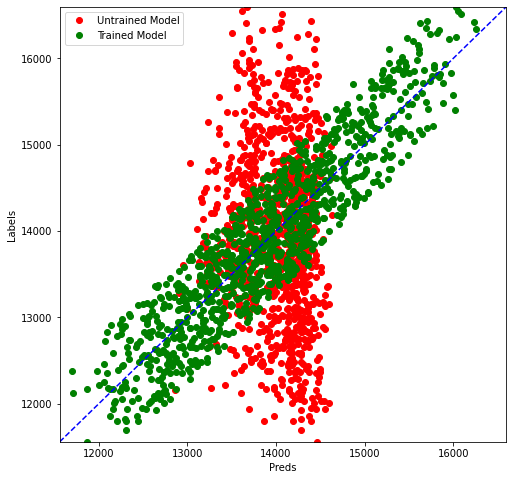

In [18]:
price_untrained = [convert_label_value(y) for y in predictions_on_untrain_model]
price_trained = [convert_label_value(y) for y in predictions_on_train_model]
price_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_untrained, price_trained, price_test)